#### Classification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel, ViTConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

pretrain_loader = train_loader

# Masked Autoencoder Class...
class MaskedAutoencoder(nn.Module):
    def __init__(self, vit_model, mask_ratio=0.75):
        super(MaskedAutoencoder, self).__init__()
        self.vit = vit_model
        self.mask_ratio = mask_ratio
        self.decoder = nn.Linear(vit_model.config.hidden_size, vit_model.config.patch_size ** 2 * 3)

    def forward(self, x, mask=True):
        batch_size, _, height, width = x.shape
        patch_size = self.vit.config.patch_size

        patches = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        patches = patches.contiguous().view(batch_size, 3, -1, patch_size * patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(batch_size, -1, patch_size * patch_size * 3)

        # Apply masking...
        if mask:
            num_patches = patches.shape[1]
            num_masked = int(self.mask_ratio * num_patches)
            mask_indices = torch.randperm(num_patches)[:num_masked]
            patches[:, mask_indices, :] = 0

        # Encode using ViT...
        encoded = self.vit(pixel_values=x).last_hidden_state

        decoded = self.decoder(encoded[:, 1:, :])

        grid_size = int((decoded.shape[1])**0.5)
        decoded = decoded.view(batch_size, grid_size, grid_size, patch_size, patch_size, 3)
        decoded = decoded.permute(0, 5, 1, 3, 2, 4).contiguous()
        reconstructed = decoded.view(batch_size, 3, height, width)

        return reconstructed

# ViT-MAE Classification Model...
class ViTMAEClassification(nn.Module):
    def __init__(self, mae_model, num_classes):
        super(ViTMAEClassification, self).__init__()
        self.mae = mae_model
        self.classifier = nn.Linear(mae_model.vit.config.hidden_size, num_classes)

    def forward(self, x):
        encoded = self.mae.vit(pixel_values=x).pooler_output
        return self.classifier(encoded)

vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", config=vit_config)
mae_model = MaskedAutoencoder(vit_model)
vitmae_cls_model = ViTMAEClassification(mae_model, num_classes=10).to(device)

optimizer_mae = Adam(mae_model.parameters(), lr=1e-4)
criterion_mae = nn.MSELoss()
optimizer_cls = Adam(vitmae_cls_model.parameters(), lr=1e-4)
criterion_cls = CrossEntropyLoss()

def pretrain_mae(model, loader, optimizer, criterion, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for images, _ in loader:
            images = images.to(device)
            optimizer.zero_grad()

            reconstructed = model(images, mask=True)
            loss = criterion(reconstructed, images)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            total_correct += torch.isclose(reconstructed, images, atol=0.1).sum().item()
            total_samples += images.numel()

        accuracy = (total_correct / total_samples) * 100
        print(f"Epoch {epoch+1}/{epochs}, Pretrain Loss: {total_loss/len(loader):.4f}, Pretrain Accuracy: {accuracy:.2f}%")

def train_classification(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predictions = torch.argmax(outputs, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    return total_loss / len(loader), accuracy

def validate_classification(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    return total_loss / len(loader), accuracy

print("Starting Pretraining...")
pretrain_mae(mae_model, pretrain_loader, optimizer_mae, criterion_mae, device, epochs=3)

print("Starting Fine-tuning...")
num_epochs = 3
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_classification(vitmae_cls_model, train_loader, optimizer_cls, criterion_cls, device)
    val_loss, val_accuracy = validate_classification(vitmae_cls_model, test_loader, criterion_cls, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

torch.save(vitmae_cls_model.state_dict(), "vit_mae_mnist_classification_model.pth")
print("Model saved successfully!")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 898kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.04MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Starting Pretraining...
Epoch 1/3, Pretrain Loss: 0.0094, Pretrain Accuracy: 95.38%
Epoch 2/3, Pretrain Loss: 0.0001, Pretrain Accuracy: 99.99%
Epoch 3/3, Pretrain Loss: 0.0000, Pretrain Accuracy: 100.00%
Starting Fine-tuning...
Epoch 1/3, Train Loss: 0.1712, Train Accuracy: 94.19%, Val Loss: 0.0742, Val Accuracy: 98.05%
Epoch 2/3, Train Loss: 0.0361, Train Accuracy: 98.92%, Val Loss: 0.0532, Val Accuracy: 98.31%
Epoch 3/3, Train Loss: 0.0287, Train Accuracy: 99.18%, Val Loss: 0.0583, Val Accuracy: 98.23%
Model saved successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel, ViTConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
pretrain_loader = train_loader

# Masked Autoencoder Class...
class MaskedAutoencoder(nn.Module):
    def __init__(self, vit_model, mask_ratio=0.75):
        super(MaskedAutoencoder, self).__init__()
        self.vit = vit_model
        self.mask_ratio = mask_ratio
        self.decoder = nn.Linear(vit_model.config.hidden_size, vit_model.config.patch_size ** 2 * 3)

    def forward(self, x, mask=True):
        batch_size, _, height, width = x.shape
        patch_size = self.vit.config.patch_size

        patches = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        patches = patches.contiguous().view(batch_size, 3, -1, patch_size * patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(batch_size, -1, patch_size * patch_size * 3)

        # Apply masking..
        if mask:
            num_patches = patches.shape[1]
            num_masked = int(self.mask_ratio * num_patches)
            mask_indices = torch.randperm(num_patches)[:num_masked]
            patches[:, mask_indices, :] = 0

        # Encode using ViT..
        encoded = self.vit(pixel_values=x).last_hidden_state

        decoded = self.decoder(encoded[:, 1:, :])

        grid_size = int((decoded.shape[1])**0.5)
        decoded = decoded.view(batch_size, grid_size, grid_size, patch_size, patch_size, 3)
        decoded = decoded.permute(0, 5, 1, 3, 2, 4).contiguous()
        reconstructed = decoded.view(batch_size, 3, height, width)

        return reconstructed

# ViT-MAE Classification Model..
class ViTMAEClassification(nn.Module):
    def __init__(self, mae_model, num_classes):
        super(ViTMAEClassification, self).__init__()
        self.mae = mae_model
        self.classifier = nn.Linear(mae_model.vit.config.hidden_size, num_classes)

    def forward(self, x):
        encoded = self.mae.vit(pixel_values=x).pooler_output
        return self.classifier(encoded)

vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", config=vit_config)
mae_model = MaskedAutoencoder(vit_model)
vitmae_cls_model = ViTMAEClassification(mae_model, num_classes=10).to(device)

optimizer_mae = Adam(mae_model.parameters(), lr=1e-4)
criterion_mae = nn.MSELoss()
optimizer_cls = Adam(vitmae_cls_model.parameters(), lr=1e-4)
criterion_cls = CrossEntropyLoss()

def pretrain_mae(model, loader, optimizer, criterion, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for images, _ in loader:
            images = images.to(device)
            optimizer.zero_grad()

            reconstructed = model(images, mask=True)
            loss = criterion(reconstructed, images)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            total_correct += torch.isclose(reconstructed, images, atol=0.1).sum().item()
            total_samples += images.numel()

        accuracy = (total_correct / total_samples) * 100
        print(f"Epoch {epoch+1}/{epochs}, Pretrain Loss: {total_loss/len(loader):.4f}, Pretrain Accuracy: {accuracy:.2f}%")

def train_classification(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predictions = torch.argmax(outputs, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    return total_loss / len(loader), accuracy

def validate_classification(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    return total_loss / len(loader), accuracy

print("Starting Pretraining...")
pretrain_mae(mae_model, pretrain_loader, optimizer_mae, criterion_mae, device, epochs=3)

print("Starting Fine-tuning...")
num_epochs = 3
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_classification(vitmae_cls_model, train_loader, optimizer_cls, criterion_cls, device)
    val_loss, val_accuracy = validate_classification(vitmae_cls_model, test_loader, criterion_cls, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

torch.save(vitmae_cls_model.state_dict(), "vit_mae_mnist_classification_model.pth")
print("Model saved successfully!")


Starting Pretraining...
Epoch 1/3, Pretrain Loss: 0.0096, Pretrain Accuracy: 95.42%
Epoch 2/3, Pretrain Loss: 0.0001, Pretrain Accuracy: 99.98%
Epoch 3/3, Pretrain Loss: 0.0000, Pretrain Accuracy: 100.00%
Starting Fine-tuning...
Epoch 1/3, Train Loss: 0.1454, Train Accuracy: 95.21%, Val Loss: 0.0462, Val Accuracy: 98.73%
Epoch 2/3, Train Loss: 0.0362, Train Accuracy: 99.02%, Val Loss: 0.0402, Val Accuracy: 98.66%
Epoch 3/3, Train Loss: 0.0297, Train Accuracy: 99.14%, Val Loss: 0.0238, Val Accuracy: 99.28%
Model saved successfully!


#### Segmentation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel, ViTConfig
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Dummy MNIST segmentation dataset...
class MNISTSegmentationDataset(datasets.MNIST):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        if not isinstance(image, Image.Image):
            image = transforms.ToPILImage()(image)

        grayscale_image = np.array(image.convert("L"))
        mask = np.zeros_like(grayscale_image, dtype=np.uint8)
        digit_pixels = grayscale_image > 128
        mask[digit_pixels] = label

        mask = Image.fromarray(mask)

        if self.transform is not None:
            image = self.transform(image)
            mask = transforms.Resize((224, 224))(mask)
            mask = torch.tensor(np.array(mask), dtype=torch.long)

        return image, mask

train_dataset = MNISTSegmentationDataset(root="./data", train=True, download=True, transform=transform)
test_dataset = MNISTSegmentationDataset(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Masked Autoencoder Class..
class MaskedAutoencoder(nn.Module):
    def __init__(self, vit_model, mask_ratio=0.75):
        super(MaskedAutoencoder, self).__init__()
        self.vit = vit_model
        self.mask_ratio = mask_ratio

    def forward(self, x, mask=True):
        encoded = self.vit(pixel_values=x).last_hidden_state[:, 1:, :]
        return encoded

# ViT-MAE Segmentation Model...
class ViTMAESegmentation(nn.Module):
    def __init__(self, mae_model, num_classes):
        super(ViTMAESegmentation, self).__init__()
        self.mae = mae_model
        self.segmentation_decoder = nn.Conv2d(mae_model.vit.config.hidden_size, num_classes, kernel_size=1)

    def forward(self, x):
        encoded = self.mae(x)
        batch_size, seq_len, hidden_size = encoded.shape
        grid_size = int(seq_len ** 0.5)
        encoded = encoded.permute(0, 2, 1).view(batch_size, hidden_size, grid_size, grid_size)
        return F.interpolate(self.segmentation_decoder(encoded), size=(224, 224), mode="bilinear")

vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", config=vit_config)
mae_model = MaskedAutoencoder(vit_model)
vitmae_seg_model = ViTMAESegmentation(mae_model, num_classes=10).to(device)

optimizer_seg = Adam(vitmae_seg_model.parameters(), lr=1e-4)
criterion_seg = CrossEntropyLoss()

def calculate_accuracy(predictions, masks):
    preds = torch.argmax(predictions, dim=1)
    correct = (preds == masks).sum().item()
    total = masks.numel()
    return correct / total * 100

def train_segmentation(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_accuracy = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += calculate_accuracy(outputs, masks)
    return total_loss / len(loader), total_accuracy / len(loader)

def validate_segmentation(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            total_accuracy += calculate_accuracy(outputs, masks)
    return total_loss / len(loader), total_accuracy / len(loader)

num_epochs = 3
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_segmentation(vitmae_seg_model, train_loader, optimizer_seg, criterion_seg, device)
    val_loss, val_accuracy = validate_segmentation(vitmae_seg_model, test_loader, criterion_seg, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

torch.save(vitmae_seg_model.state_dict(), "vit_mae_mnist_segmentation_model.pth")
print("Model saved successfully!")


Epoch 1/3, Train Loss: 0.1224, Train Accuracy: 94.11%, Validation Loss: 0.0959, Validation Accuracy: 94.42%
Epoch 2/3, Train Loss: 0.0965, Train Accuracy: 94.36%, Validation Loss: 0.0944, Validation Accuracy: 94.42%
Epoch 3/3, Train Loss: 0.0947, Train Accuracy: 94.36%, Validation Loss: 0.0930, Validation Accuracy: 94.39%
Model saved successfully!


#### Inference

In [ ]:
from torchvision import datasets
from PIL import Image

mnist_data = datasets.MNIST(root="./data", train=True, download=True)
image, label = mnist_data[0]
image.save("sample_digit.png")
print(f"Sample digit saved with label {label}.")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.12MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Sample digit saved with label 5.


In [ ]:
import os
from torchvision import datasets
from PIL import Image

mnist_data = datasets.MNIST(root="./data", train=True, download=True)
output_dir = "./mnist_images"
os.makedirs(output_dir, exist_ok=True)

num_images_to_save = 10

for idx in range(num_images_to_save):
    image, label = mnist_data[idx]
    file_name = f"digit_{idx}_label_{label}.png"
    image.save(os.path.join(output_dir, file_name))
    print(f"Saved: {file_name}")


Saved: digit_0_label_5.png
Saved: digit_1_label_0.png
Saved: digit_2_label_4.png
Saved: digit_3_label_1.png
Saved: digit_4_label_9.png
Saved: digit_5_label_2.png
Saved: digit_6_label_1.png
Saved: digit_7_label_3.png
Saved: digit_8_label_1.png
Saved: digit_9_label_4.png


In [ ]:
import torch
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

num_classes = 10
vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", config=vit_config)
mae_model = MaskedAutoencoder(vit_model)
vitmae_cls_model = ViTMAEClassification(mae_model, num_classes=num_classes)
vitmae_cls_model.load_state_dict(torch.load("vit_mae_mnist_classification_model.pth"))
vitmae_cls_model.eval().to(device)

def infer_image(image_path):
    image = Image.open(image_path).convert("L")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = vitmae_cls_model(image)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities).item()

    return predicted_class, probabilities.squeeze().cpu().numpy()

image_path = "./sample_digit.png"
predicted_class, probabilities = infer_image(image_path)

print(f"Predicted Class: {predicted_class}")
print(f"Probabilities: {probabilities}")


<ipython-input-10-e5e290e8c9b2>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vitmae_cls_model.load_state_dict(torch.load("vit_mae_mnist_classification_model.pth"))


Predicted Class: 5
Probabilities: [5.5943616e-05 2.2727965e-05 3.1525989e-05 2.3717815e-02 6.1969276e-06
 9.7576809e-01 7.9765276e-05 1.6665648e-05 2.1005652e-04 9.1156078e-05]


In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

num_classes = 10
vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", config=vit_config)
mae_model = MaskedAutoencoder(vit_model)
vitmae_cls_model = ViTMAEClassification(mae_model, num_classes=num_classes)
vitmae_cls_model.load_state_dict(torch.load("vit_mae_mnist_classification_model.pth"))
vitmae_cls_model.eval().to(device)

def infer_image(image_path):
    image = Image.open(image_path).convert("L")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = vitmae_cls_model(image)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities).item()

    return predicted_class, probabilities.squeeze().cpu().numpy()

def infer_multiple_images(image_dir):
    results = {}
    for file_name in os.listdir(image_dir):
        if file_name.endswith(".png")
            image_path = os.path.join(image_dir, file_name)
            predicted_class, probabilities = infer_image(image_path)
            results[file_name] = (predicted_class, probabilities)

    return results

image_dir = "./mnist_images"
results = infer_multiple_images(image_dir)

for file_name, (predicted_class, probabilities) in results.items():
    print(f"Image: {file_name}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Probabilities: {probabilities}")


<ipython-input-4-5d32e3f70714>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vitmae_cls_model.load_state_dict(torch.load("vit_mae_mnist_classification_model.pth"))


Image: digit_8_label_1.png
Predicted Class: 1
Probabilities: [3.4404577e-06 9.9988592e-01 1.9309666e-05 8.2684492e-06 8.2172191e-06
 2.3520792e-05 1.5027029e-05 2.2098815e-05 8.1413382e-06 6.0344437e-06]
Image: digit_0_label_5.png
Predicted Class: 5
Probabilities: [1.1994301e-04 7.1267707e-05 3.4978988e-05 7.6753320e-03 1.3602793e-05
 9.9161834e-01 2.5402015e-04 9.4690644e-05 6.8872483e-05 4.8971811e-05]
Image: digit_4_label_9.png
Predicted Class: 9
Probabilities: [5.0362636e-05 5.4740434e-05 1.8019262e-05 6.6647095e-05 2.6519754e-04
 4.0358482e-05 1.3636540e-05 4.6814519e-05 9.6975622e-04 9.9847454e-01]
Image: digit_3_label_1.png
Predicted Class: 1
Probabilities: [5.0236276e-06 9.9989271e-01 1.6822240e-05 4.2889078e-06 1.0141408e-05
 1.6110507e-05 2.3902450e-05 1.7521363e-05 9.1847096e-06 4.2842066e-06]
Image: digit_1_label_0.png
Predicted Class: 0
Probabilities: [9.9961925e-01 9.5052374e-06 1.8977931e-05 7.4208592e-06 1.0301458e-05
 9.4409370e-05 1.8945537e-04 7.8049234e-06 2.1229480

<ipython-input-10-b6faf8627994>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vitmae_seg_model.load_state_dict(torch.load("vit_mae_mnist_segmentation_model.pth"))


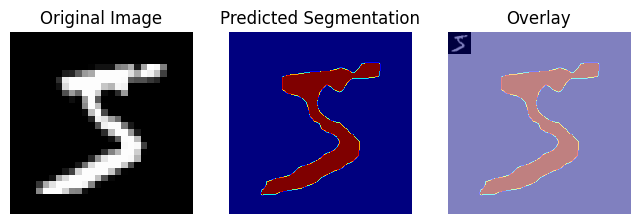

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

num_classes = 10
vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", config=vit_config)
mae_model = MaskedAutoencoder(vit_model)
vitmae_seg_model = ViTMAESegmentation(mae_model, num_classes=num_classes)
vitmae_seg_model.load_state_dict(torch.load("vit_mae_mnist_segmentation_model.pth"))
vitmae_seg_model.eval().to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

def infer_segmentation(image_path):

    image = Image.open(image_path).convert("L")
    image_transformed = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = vitmae_seg_model(image_transformed)
        predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    return image, predicted_mask

image_path = "./sample_digit.png"
original_image, predicted_mask = infer_segmentation(image_path)

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Predicted Segmentation")
plt.imshow(predicted_mask, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(original_image, cmap="gray")
plt.imshow(predicted_mask, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()



In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTConfig, ViTModel

num_classes = 10
vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", config=vit_config)
mae_model = MaskedAutoencoder(vit_model)
vitmae_seg_model = ViTMAESegmentation(mae_model, num_classes=num_classes)
vitmae_seg_model.load_state_dict(torch.load("vit_mae_mnist_segmentation_model.pth"))
vitmae_seg_model.eval().to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

def infer_segmentation(image_path):
    image = Image.open(image_path).convert("L")
    image_transformed = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = vitmae_seg_model(image_transformed)
        predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    return image, predicted_mask

def batch_infer_segmentation(image_dir, output_dir="./output_results"):
    os.makedirs(output_dir, exist_ok=True)
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(".png")]

    for image_path in image_paths:
        original_image, predicted_mask = infer_segmentation(image_path)
        image_name = os.path.basename(image_path).split('.')[0]

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(original_image, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Predicted Segmentation")
        plt.imshow(predicted_mask, cmap="jet")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Overlay")
        plt.imshow(original_image, cmap="gray")
        plt.imshow(predicted_mask, cmap="jet", alpha=0.5)
        plt.axis("off")

        plt.savefig(os.path.join(output_dir, f"{image_name}_segmentation.png"))
        print(f"Saved segmentation result for {image_name}")
        plt.close()

image_dir = "./mnist_images"
batch_infer_segmentation(image_dir)


<ipython-input-15-37cd74dcd8a8>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vitmae_seg_model.load_state_dict(torch.load("vit_mae_mnist_segmentation_model.pth"))


Saved segmentation result for digit_8_label_1
Saved segmentation result for digit_0_label_5
Saved segmentation result for digit_4_label_9
Saved segmentation result for digit_3_label_1
Saved segmentation result for digit_1_label_0
Saved segmentation result for digit_5_label_2
Saved segmentation result for digit_2_label_4
Saved segmentation result for digit_9_label_4
Saved segmentation result for digit_7_label_3
Saved segmentation result for digit_6_label_1


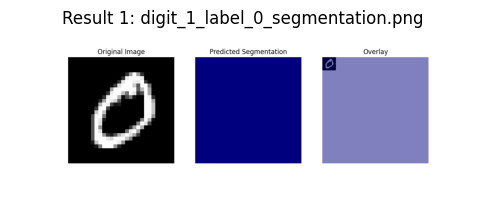

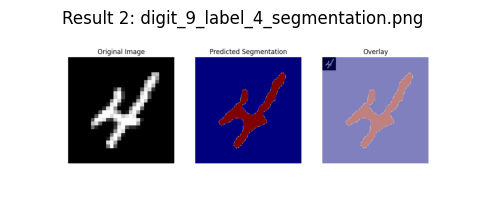

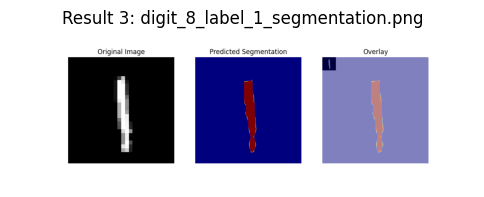

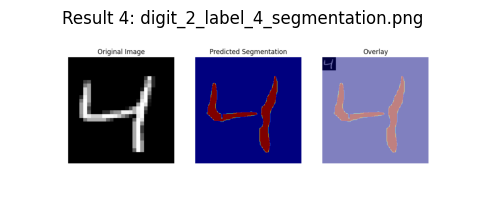

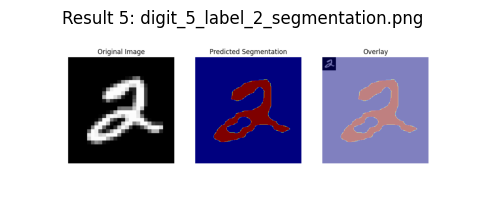

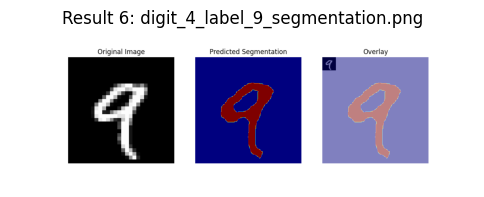

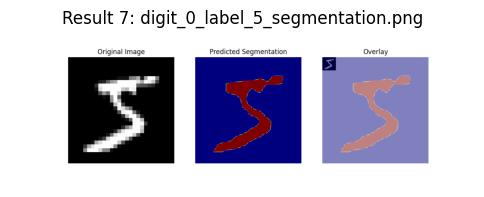

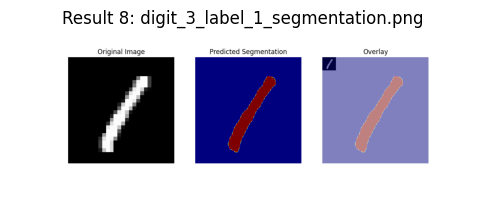

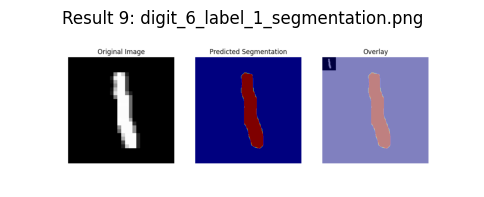

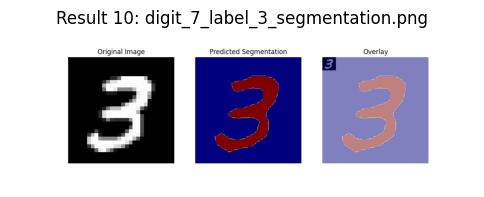

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

output_dir = "./output_results"

def visualize_saved_results(output_dir, num_images=5):
    saved_images = [img for img in os.listdir(output_dir) if img.endswith(".png")]

    if len(saved_images) == 0:
        print(f"No images found in {output_dir}. Ensure the inference script ran successfully.")
        return

    num_images = min(num_images, len(saved_images))

    for idx, image_name in enumerate(saved_images[:num_images]):
        image_path = os.path.join(output_dir, image_name)
        image = Image.open(image_path)

        plt.figure(figsize=(6, 6))
        plt.title(f"Result {idx+1}: {image_name}")
        plt.imshow(image)
        plt.axis("off")
        plt.show()

visualize_saved_results(output_dir, num_images=10)
